In [1]:
%load_ext line_profiler

import tensorflow as tf
import neural_tangents as nt
from neural_tangents import stax

from jax.config import config; config.update("jax_enable_x64", True)
import jax.numpy as np
from jax import random, jit

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def find_h(N, L, d, n=1, bias=True):
    # Modified from https://github.com/mariogeiger/nn_jamming/blob/master/constN.py
    # TODO: bias=False?
    '''
        For a network with: 
        
        d input dimensionality, 
        L layers, 
        N total parameters, 
        n final outputs,
        
        this finds the corresponding width h 
    '''
    assert L >= 1

    if L == 1:
        # solve : N = h*(d+1) + n*(h+1)
        h = (N - n) / (d + n + 1)
    else:
        # solve : N = h*(d+1) + (L-1)*h*(h+1) + n*(h+1)
        h = -(d+L+n - ((d+L+n)**2 + 4*(L-1)*(N-n))**.5)/(2*(L-1))
    return round(h)

def find_N(h, L, d, n=1):
    return h*(d+1) + (L-1)*h*(h+1) + n*(h+1)

Prepare data

In [3]:
# Load data from https://www.openml.org/d/554
from sklearn.datasets import fetch_openml
X_raw, y_raw = fetch_openml('mnist_784', version=1, return_X_y=True)

In [4]:
P = 2000 #train
P_total = int(1.75*P)

X = X_raw[:P_total]
y = (2*(y_raw.astype(int) % 2) - 1)[:P_total].reshape(-1,1)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1-P/P_total, random_state=42)
len(X_train)

2000

In [6]:
from sklearn.decomposition import PCA
n_components = 10
pca = PCA(n_components = n_components)
pca = pca.fit(X_train)

In [7]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# project to hyper-sphere of radius sqrt(n_components)
X_train = np.sqrt(n_components) * X_train / np.linalg.norm(X_train, axis = 1, keepdims=True)
X_test = np.sqrt(n_components) * X_test / np.linalg.norm(X_test, axis = 1, keepdims=True)

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Prepare network

In [8]:
d = n_components
L = 2
N = 4*P

h = find_h(N, L, d)
N/P, h

(4.0, 83)

In [9]:
init_fn, apply_fn, kernel_fn_inf = stax.serial(
    *[stax.Dense(h), stax.Erf()]*L,
    stax.Dense(1)
)

In [10]:
initkey = random.PRNGKey(123)
_, init_params = init_fn(initkey, X_train.shape)

In [11]:
from jax.api import jacrev
from jax import tree_util

@jit
def jacobian_leaf_flattener(x):
    #Flatten everything but first two dimensions (batch_size, n_out)
    param_count = int(np.prod(x.shape[2:]))
    return np.reshape(x, x.shape[:2] + (param_count,))

def network_jacobian(apply_fn, params, inputs):
    """
        TODO: speed me up/find a way to @jit me?
    """
    jac = jacrev(apply_fn)(params, inputs)
    leaves, _ = tree_util.tree_flatten(jac)
    
    return np.concatenate([jacobian_leaf_flattener(leaf) for leaf in leaves], -1)

In [12]:
@jit
def mse(y_pred, y_true):
    return np.mean(np.sum((y_pred - y_true)**2, -1))

@jit
def acc(y_pred, y_true):
    return np.mean((y_pred*y_true) > 0)

In [13]:
@jit
def lstsq_reg(X, y, lamb=0., rcond=None):
    """
        Computes coefficients `b` for the regularized least squares problem
            b = argmin_b |(y-Xb)|^2 + lamb*|b|^2
        
        Based on algorithm for pseudoinverse from 
            https://github.com/numpy/numpy/blob/v1.17.0/numpy/linalg/linalg.py#L1890-L1979
        and
            https://jax.readthedocs.io/en/latest/_modules/jax/numpy/linalg.html#lstsq
        with modification to regularized pseudoinverse given by
            https://en.wikipedia.org/wiki/Tikhonov_regularization#Relation_to_singular-value_decomposition_and_Wiener_filter
    """
    X = np.conj(X)
    
    u, s, v = np.linalg.svd(X, full_matrices=False)
    
    if rcond is None:
        dtype = X.dtype
        rcond = np.finfo(train_features.dtype).eps * max(X.shape)
    cutoff = rcond * np.max(s)
    mask = s >= cutoff
    safe_s = np.where(mask, s, 1.)
    
    d = np.where(mask, safe_s / (safe_s**2 + lamb**2), 0.)
    b = v.T @ (u * d).T @ y 
    
    return b

In [14]:
apply_fn = jit(apply_fn)
train_f0 = apply_fn(init_params, X_train)
test_f0 = apply_fn(init_params, X_test)

train_features = network_jacobian(apply_fn, init_params, X_train).reshape(len(X_train), -1)
test_features = network_jacobian(apply_fn, init_params, X_test).reshape(len(X_test), -1)

In [15]:
coeffs = lstsq_reg(train_features, y_train-train_f0, lamb = 1e-3)

In [16]:
y_train_pred = train_f0 + train_features @ coeffs
y_test_pred = test_f0 + test_features @ coeffs

In [17]:
mse(y_test_pred, y_test), acc(y_test_pred, y_test)

(DeviceArray(0.71777319, dtype=float64),
 DeviceArray(0.84666667, dtype=float64))

In [18]:
mse(y_train_pred, y_train), acc(y_train_pred, y_train)

(DeviceArray(5.26116872e-06, dtype=float64), DeviceArray(1., dtype=float64))

## Train loop

In [19]:
from tqdm import notebook as tqdm

In [20]:
lamb = 1e-8

train_mse = []
train_acc = []

test_mse = []
test_acc = []

Ns = []

for hi in tqdm.trange(h, 0, -1):
    Ns.append(find_N(hi, L, d))
    
    init_fn, apply_fn, kernel_fn_inf = stax.serial(
        *[stax.Dense(hi), stax.Erf()]*L,
        stax.Dense(1)
    )
    apply_fn = jit(apply_fn)
    _, init_params = init_fn(initkey, X_train.shape)
    
    train_f0 = apply_fn(init_params, X_train)
    test_f0 = apply_fn(init_params, X_test)

    train_features = network_jacobian(apply_fn, init_params, X_train)
    train_features = train_features.reshape(len(X_train), -1)
    
    test_features = network_jacobian(apply_fn, init_params, X_test)
    test_features.reshape(len(X_test), -1)
    
    coeffs = lstsq_reg(train_features, y_train-train_f0, lamb=lamb)
    
    y_train_pred = train_f0 + train_features @ coeffs
    y_test_pred = test_f0 + test_features @ coeffs
    
    train_mse.append(mse(y_train_pred, y_train))
    train_acc.append(acc(y_train_pred, y_train))
    
    test_mse.append(mse(y_test_pred, y_test))
    test_acc.append(acc(y_test_pred, y_test))

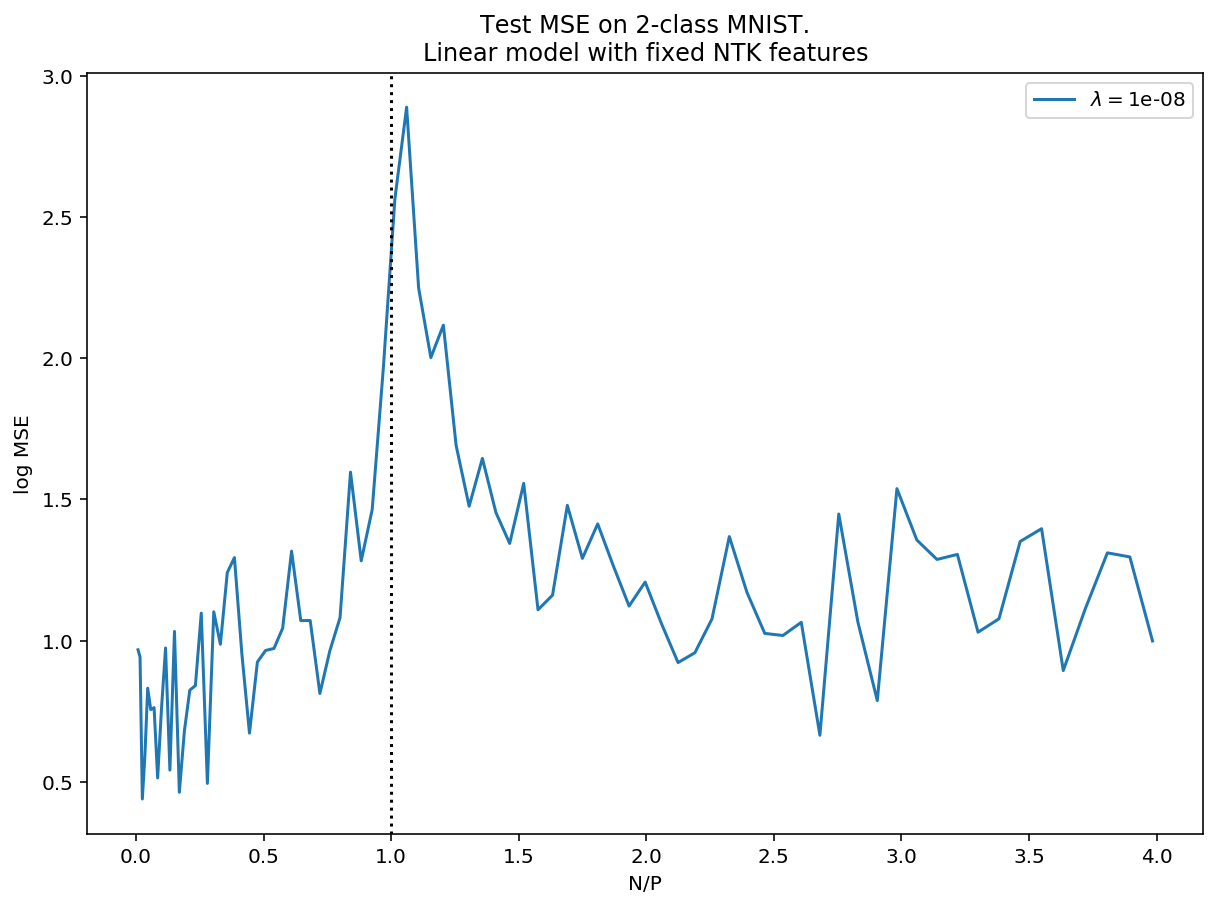

In [21]:
fig = plt.figure(figsize=(10,7))
plt.plot(np.array(Ns)/P, np.log(np.array(test_mse)), label=f'$\lambda = ${lamb:.0e}')
plt.axvline(1, ls=':', color='k')
plt.legend()
plt.xlabel('N/P')
plt.ylabel('log MSE')
plt.title('Test MSE on 2-class MNIST.\nLinear model with fixed NTK features')
fig.savefig('test_mse.svg')

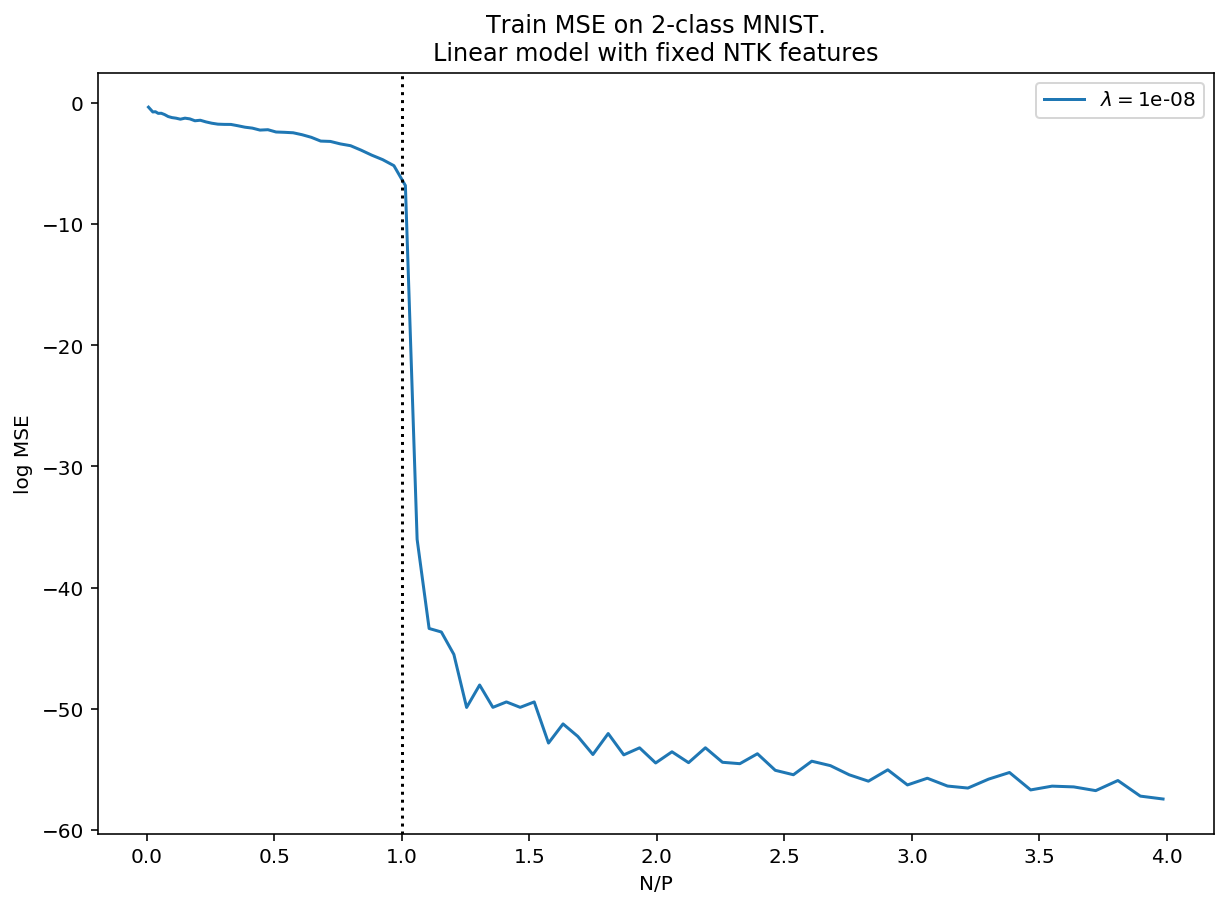

In [22]:
fig = plt.figure(figsize=(10,7))
plt.plot(np.array(Ns)/P, np.log(np.array(train_mse)), label=f'$\lambda = ${lamb:.0e}')
plt.axvline(1, ls=':', color='k')

plt.legend()
plt.xlabel('N/P')
plt.ylabel('log MSE')
plt.title('Train MSE on 2-class MNIST.\nLinear model with fixed NTK features')
fig.savefig('train_mse.svg')

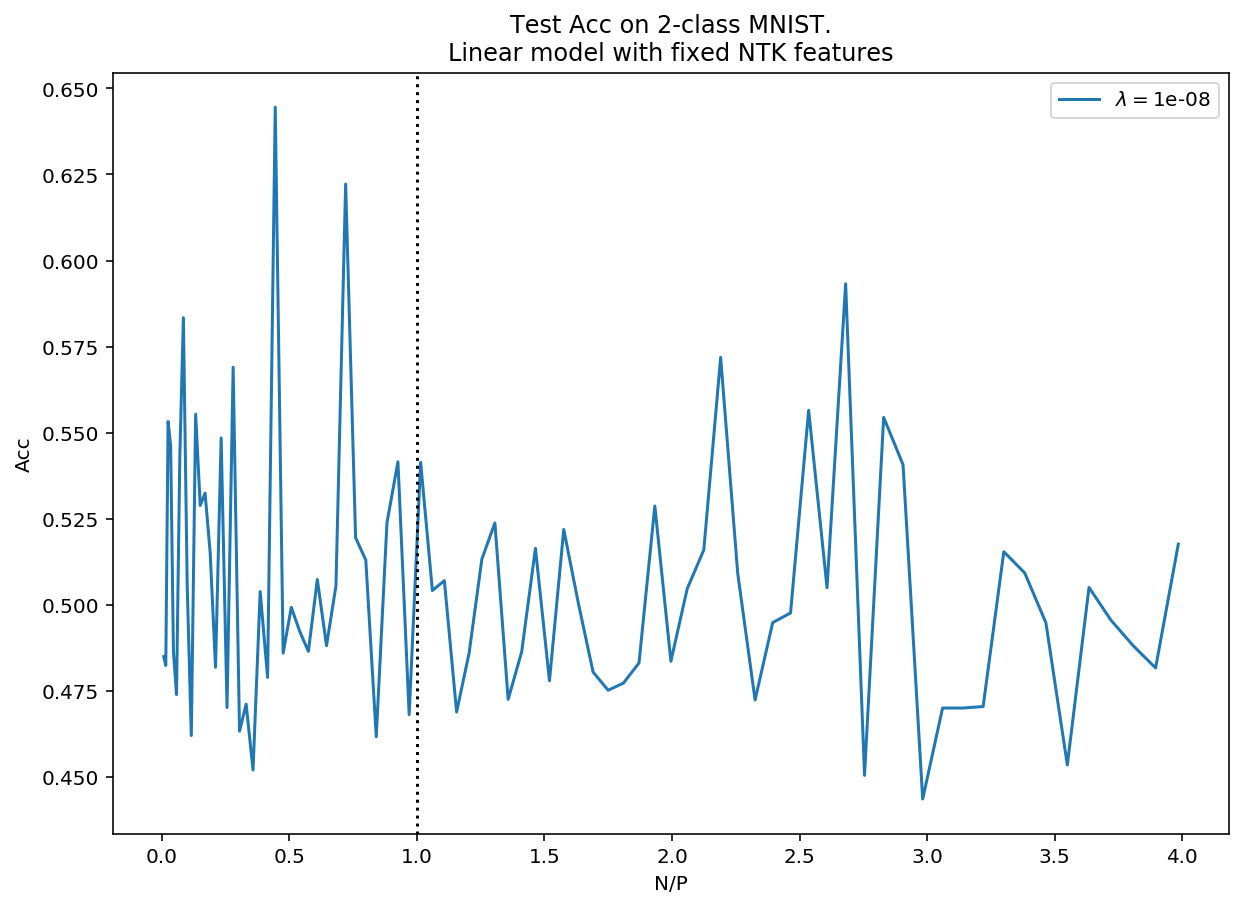

In [26]:
fig = plt.figure(figsize=(10,7))
plt.plot(np.array(Ns)/P, test_acc, label=f'$\lambda = ${lamb:.0e}')
plt.axvline(1, ls=':', color='k')
plt.legend()
plt.xlabel('N/P')
plt.ylabel('Acc')
plt.title('Test Acc on 2-class MNIST.\nLinear model with fixed NTK features')
fig.savefig('test_acc.svg')

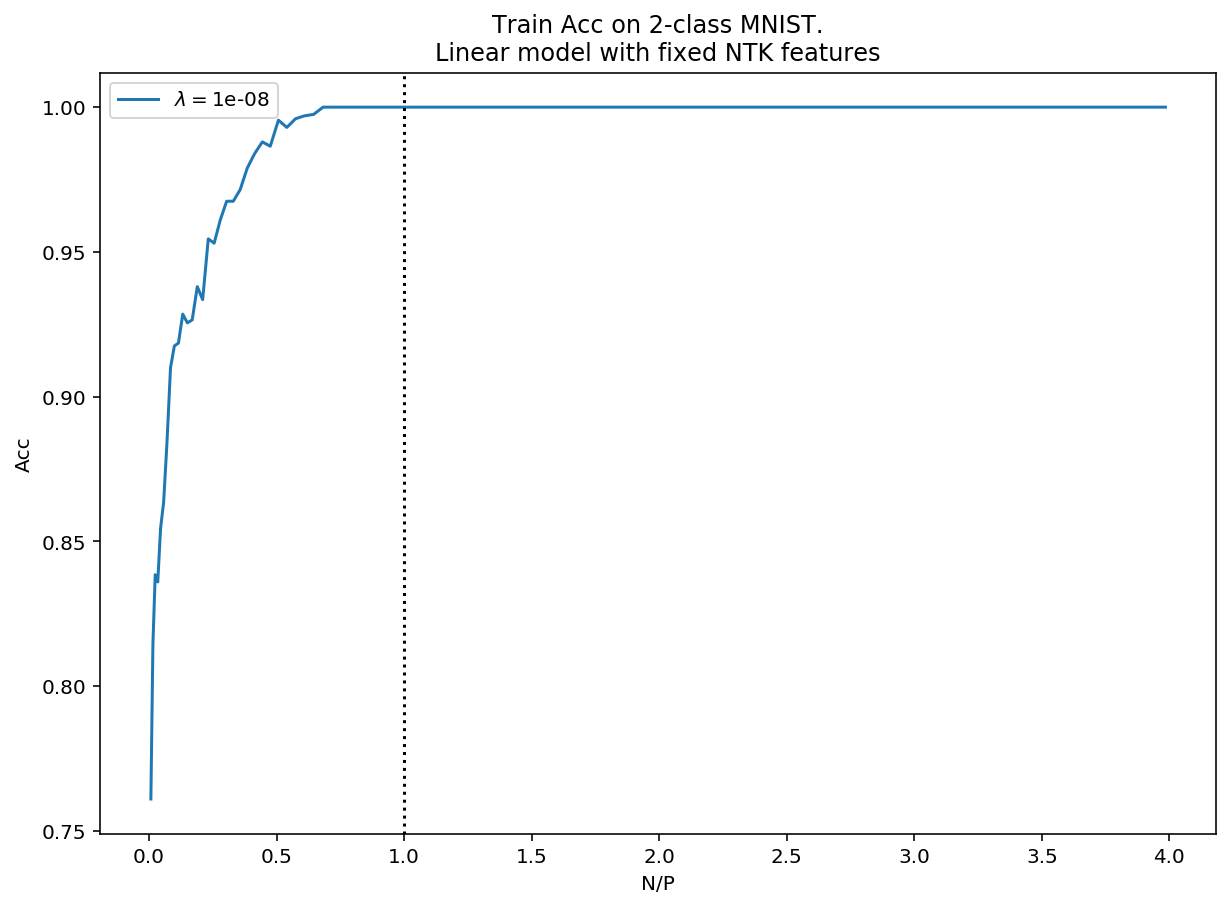

In [27]:
fig = plt.figure(figsize=(10,7))
plt.plot(np.array(Ns)/P, train_acc, label=f'$\lambda = ${lamb:.0e}')
plt.axvline(1, ls=':', color='k')
plt.legend()
plt.xlabel('N/P')
plt.ylabel('Acc')
plt.title('Train Acc on 2-class MNIST.\nLinear model with fixed NTK features')
fig.savefig('train_acc.svg')